In [1]:
try:
    from sklearnex import patch_sklearn, unpatch_sklearn
    patch_sklearn()
except:
    pass

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#モデルの構築
#それではモデルを構築しましょう。ここでは、2つの全結合の隠れ層と、1つの連続値を返す出力層からなる、
#Sequentialモデルを使います。モデルを構築するステップはbuild_modelという1つの関数の中に組み込みます。
#あとから2つ目のモデルを構築するためです。
def build_model(inputshape):
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[inputshape]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

#モデルの訓練
# モデルを500エポック訓練し、訓練と検証の正解率をhistoryオブジェクトに記録します。
# エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

#EPOCHS = 1000
EPOCHS = 500

# patience は改善が見られるかを監視するエポック数を表すパラメーター
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Consumption]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    #plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$Consumption^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    #plt.ylim([0,20])
    plt.legend()
    plt.show()
    
if __name__ == "__main__":
    
    pass
    
#     model = build_model(len(takamatsu_wthr.keys()))

#     history = model.fit(x_train_normed, y_train_normed, epochs=EPOCHS,
#                         validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

#     history = model.fit(train_data, train_labels, epochs=EPOCHS,
#                        validation_split = 0.2, verbose=0, callbacks=[PrintDot()])

    # ヒストリグラフ表示
#     plot_history(history)


...............................................................

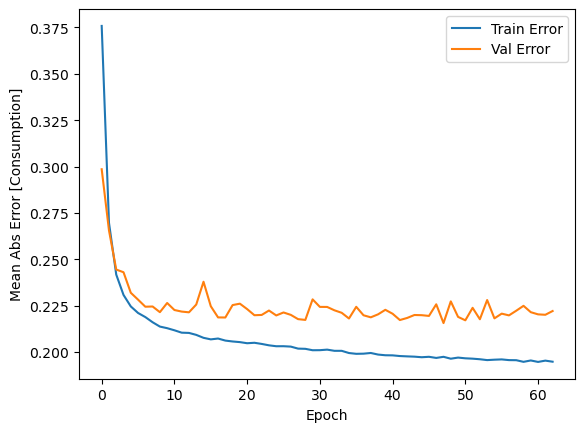

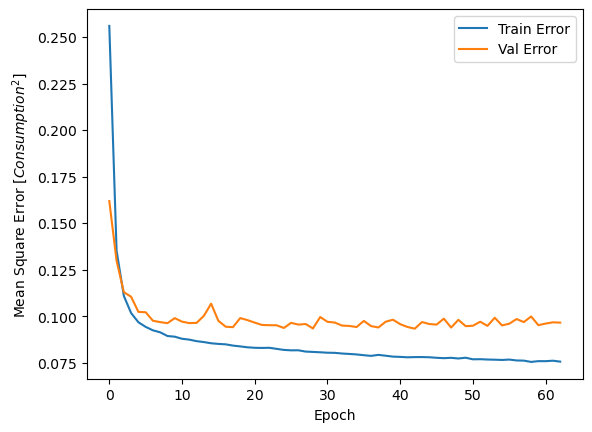

877/877 [==============================] - 2s 2ms/step
説明変数 = temperature, sunhour1, sunhour2, insolation, month, hour, dayofweek
訓練スコア = 0.923457, 検証スコア = 0.901852


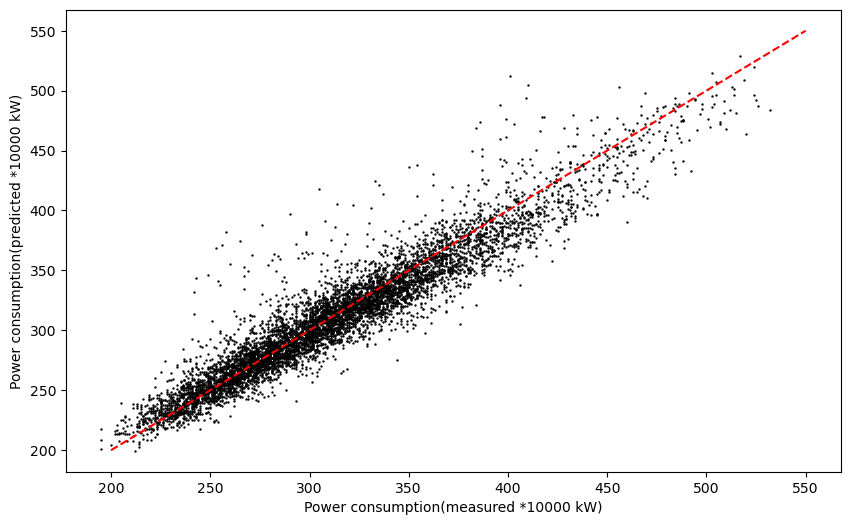

In [3]:
# coding: utf-8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

def set_holiday(takamatsu, year_from = "2017", year_to = "2020"):
    holiday = pd.read_csv(
    'data/syukujitsu.csv',
    skiprows=1,
    names=['DATE', 'HOLIDAY-NAME'],
    parse_dates={'date': ['DATE']},
    index_col = "date",
    encoding='cp932')

    holiday["holiday"] = holiday.index

    from_ = "{}-01-01".format(year_from)
    to_ = "{}-12-31".format(year_to)
    holiday_year = holiday.loc[from_: to_,"holiday"]

    for hly in holiday_year:
        # 祝日を日曜日(6)に設定する
        ymd = pd.to_datetime(hly)
        takamatsu.loc[ymd.strftime('%Y-%m-%d'),["dayofweek"]]=6.0

    return takamatsu.dropna()

# 四国電力の電力消費量データを読み込み
ed = [pd.read_csv(
    'data/juyo_shikoku_{:d}.csv'.format(year),
    skiprows=3,
    names=['DATE', 'TIME', 'consumption'],
    parse_dates={'date_hour': ['DATE', 'TIME']},
    index_col = "date_hour")
    for year in [2017, 2018, 2019, 2020]
]
elec_data = pd.concat(ed)

# 複数年の気象データを読み込み
tp = [pd.read_csv(
    './data/takamatsu{:d}.csv'.format(year),
    skiprows=5,
    names=['DATETIME', 'temperature', 'temperature2', 'temperature3', 
           'sunhour1','sunhour2','sunhour3','sunhour4',
           'insolation','insolation2','insolation3',
           'humid','humid2','humid3'],
    parse_dates={'date_hour': ["DATETIME"]},
    index_col='date_hour')
    for year in [2017, 2018, 2019, 2020]
]

tmp = pd.concat(tp)

# 月, 日, 時の取得
tmp["month"] = tmp.index.month
tmp['day'] = tmp.index.day
tmp['dayofyear'] = tmp.index.dayofyear
tmp['hour'] = tmp.index.hour
tmp['dayofweek'] = tmp.index.dayofweek

# 気象データと電力消費量データをいったん統合して時間軸を合わせたうえで、再度分割
#variable = ["temperature","sunhour1","month","hour"]
variable = ["temperature","sunhour1","sunhour2","insolation","month","hour","dayofweek"]
# variable = ["temperature","month","hour","dayofweek"]


# takamatsu_wthr = elec_data.join(tmp[variable]).dropna()
takamatsu_tmp = elec_data.join(tmp[variable]).dropna()
takamatsu_wthr = set_holiday(takamatsu_tmp)

dmy_dayofweek =pd.get_dummies( takamatsu_wthr['dayofweek'], prefix='dwk',prefix_sep='_',drop_first=True)
takamatsu_wthr = pd.concat([takamatsu_wthr,dmy_dayofweek], axis=1)
takamatsu_wthr = takamatsu_wthr.drop('dayofweek',axis=1)

dmy_hour =pd.get_dummies( takamatsu_wthr['hour'], prefix='h',prefix_sep='_',drop_first=True)
takamatsu_wthr = pd.concat([takamatsu_wthr,dmy_hour], axis=1)
takamatsu_wthr = takamatsu_wthr.drop('hour',axis=1)

dmy_month =pd.get_dummies( takamatsu_wthr['month'], prefix='m',prefix_sep='_',drop_first=True)
takamatsu_wthr = pd.concat([takamatsu_wthr,dmy_month], axis=1)
takamatsu_wthr = takamatsu_wthr.drop('month',axis=1)

takamatsu_elec = takamatsu_wthr.pop("consumption")

# 学習と性能の評価
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression, Ridge

# model = LinearRegression()
# import sklearn.svm
# model = sklearn.svm.SVR()
# model = Ridge(random_state = 0, alpha = 0.01)
model = build_model(len(takamatsu_wthr.keys()))

# 学習データとテストデータに分割
x_train, x_test, y_train, y_test = train_test_split(
    takamatsu_wthr, takamatsu_elec, test_size=0.2,random_state=0
    )


# 訓練データを基準に標準化（平均、標準偏差で標準化）
scaler = StandardScaler()
x_train_normed = scaler.fit_transform(x_train)
# テストデータも標準化
x_test_normed = scaler.transform(x_test)

scaler2 = StandardScaler()
y_train_normed = scaler2.fit_transform(pd.DataFrame(y_train))
y_test_normed = scaler2.transform(pd.DataFrame(y_test))

# model.fit(x_train_normed, y_train_normed.ravel())
history = model.fit(x_train_normed, y_train_normed, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)


# -- 可視化 --
# 画像のサイズを設定する
plt.figure(figsize=(10, 6))

# predicted = model.predict(x_test_normed)

predicted = model.predict(x_test_normed).flatten()

score = "説明変数 = {}\n訓練スコア = {:f}, 検証スコア = {:f}".format(
          ", ".join(variable),   
          r2_score(y_train_normed.flatten(), model.predict(x_train_normed).flatten()),
          r2_score(y_test_normed.flatten(), predicted)
          )
print(score)

plt.xlabel('Power consumption(measured *10000 kW)')
plt.ylabel('Power consumption(predicted *10000 kW)')
plt.scatter(scaler2.inverse_transform(y_test_normed), scaler2.inverse_transform(predicted.reshape(-1,1)), s=0.5, color="black")
plt.plot([200, 550], [200, 550], 'r--')

#plt.savefig("predict-power-consumption-graph.png")
plt.show()


In [4]:
import joblib

filename ='weather-elec-tf2.h5'
model.save(filename,save_format='h5')

# Scaleの保存
fname = "scaler-tf2.pkl"
joblib.dump(scaler, open(fname, 'wb'))
fname = "scaler2-tf2.pkl"
joblib.dump(scaler2, open(fname, 'wb'))